# **Part 1: MNIST Digit Generation**


In the first part of this lab, we will build and train a Deep Convolutional Generative Adversarial Network [DCGAN] (https://arxiv.org/abs/1511.06434) for generation of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images.


First, let's **import the relevant packages** we'll need for this exercise.



In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

import tensorflow as tf


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers


from tensorflow.keras.datasets import mnist

Second, let's **download the MNIST repository**

In [ ]:
# Load MNIST data
# ---------------
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5     # <-- Dataset Normalization [-1:1]

X_train = X_train[:, :, :, np.newaxis]
X_test  = X_test[:, :, :, np.newaxis]


print("Training Shape: ",np.shape(X_train))

11490434/11490434 [==============================] - 2s 0us/step
Training Shape:  (60000, 28, 28, 1)


## 1.1 MNIST dataset

Now let's and display a few random samples from the dataset:

In [ ]:
def plotRealImages():
    plt.figure(figsize=(10,10))
    random_inds = np.random.choice(60000,36)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_ind = random_inds[i]
        plt.imshow(np.squeeze(X_train[image_ind]), cmap=plt.cm.binary)
        #plt.xlabel(y_train[image_ind])

plotRealImages()

Our training set is made up of 28x28 grayscale (1 channel) images of handwritten digits.


## 1.2 Neural Network for Handwritten Digit GENERATION

We'll first build two neural networks one for the 'Generator' (G) and the other for the 'Discriminator' (D), to then combine them such as to have the full GAN architecture as depicted below:

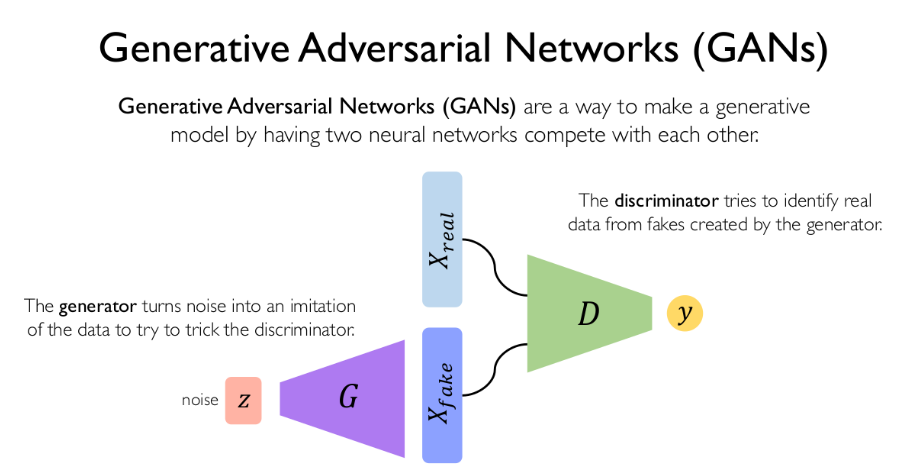


In [ ]:
# Deterministic output.
# Tired of seeing the same results every time? Comment the line below.
np.random.seed(1000)


# Dimension of THE LATENT VARIABLE VECTOR (I choose 10 you can try other values!! Expecially with the Turbulent database!!)
randomDim = 10

In [ ]:
# Generator
# ---------
def build_generator():

    generator = Sequential()

    # Input is z -> latent vector of 10 elements

    # Fully connected Layer --> FIRST HIDDEN LAYER
    generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    # Reshape from a vector of 6272 to 128 matrixes 7x7
    generator.add(Reshape((7, 7, 128)))

    # Convolutional Layer (64-filters 5x5) --> SECOND HIDDEN LAYER (#weigths are 64 x (5x5) x 128 + 64 thresholds)
    generator.add(Conv2DTranspose(64, (5,5), strides=2, padding='same'))
    generator.add(LeakyReLU(0.2))

    # Convolutional Layer (1-filter 5x5) <-- OUTPUT LAYER (#weigths TODO!!)
    generator.add(Conv2DTranspose(1, (5,5), strides=2, padding='same', activation='tanh'))
    generator.summary()

    return generator


As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the Generator model**.

In [ ]:
# Discriminator
# -------------
def build_discriminator():

    discriminator = Sequential()

    # TRY TO FIGURE OUT THE NUMBER OF HIDDEN LAYER AND THE STRUCTURE OF THIS NETWORK
    # you can use info from the summary!!

    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.summary()

    return discriminator




Here there is an [example](https://i.stack.imgur.com/YyCu2.gif) of transpose convolution on 1 channel with stride=1 and padding='same'

Here there is an [example](https://miro.medium.com/max/395/1*1VJDP6qDY9-ExTuQVEOlVg.gif) of convolution on 1 channel with stride=2 and padding='same'

Here there is an [example](https://miro.medium.com/max/395/1*nYf_cUIHFEWU1JXGwnz-Ig.gif) of convolution on 1 channel with stride=1 and padding='same'

Here there is an [example](https://miro.medium.com/max/700/1*ciDgQEjViWLnCbmX-EeSrA.gif) of convolution on 3 channels with stride=1 and padding='same'


As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the Discriminator model**.

### Build and Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) step:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.0002. Since we are performing a GAN, we'll want to use the [binary cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy).

**You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.**

In [ ]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Build and compile the generator
generator = build_generator()

generator.compile(loss='binary_crossentropy', optimizer=adam)


In [ ]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Build and compile the discriminator
# -----------------------------------
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam)


In [ ]:
# Combined network (GAN)
# ----------------------

discriminator.trainable = False # <-- Notice: All Discriminator' weights will be trained separately
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)

# AGAIN We need to COMPILE The COMBINED GAN MODEL
# -----------------------------------------------
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

If you have made changes to the Generator or/and to the Discriminator you may **you'll need to re-run the above cell to re-initialize the GAN model**.

Let's take a step back and think about the network we've just created. The first model (G) takes in input a vector of random Gaussian noise of 100 elements (LATENT VECTOR) and map it in the format of the images 2d-array (28 x 28 pixels x 1 channel). The ouput of 'G' is then taken as input by the 'D' model which should return the probability value that the current image belongs to the REAL dataset (1) or to the generated data coming from 'G' (0).


Let's define a few functions that will need to plot results and loss functions during the training

In [ ]:
# Plot the loss from each batch
# -----------------------------
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    #plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)


# Create a wall of generated MNIST images
# ---------------------------------------------------
def plotGeneratedImages(epoch=0, examples=36, dim=(6, 6), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, :,:, 0], interpolation='nearest', cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        #plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)


# Save the generator and discriminator networks (and weights) for later use
# -------------------------------------------------------------------------
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)



## The GAN is ready

It is already working, it's not trained but it is able to generate images from the input noise, and to evaluate them.

Let's try to produce some figures with the Generator before training:



In [ ]:
plotGeneratedImages()

as expected we have obtained a wall of images full of noise!

### Train the model

We're now ready to train our model, which will involve feeding the training data into the model. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training.


Let us remind that our training is not going to solve a minmax problem on the binarycrossentrophy but we wan to train separately the discriminator and the generator such as to maximize the two following quantities:

image.png

In [ ]:
# Initialize losses as empty arrays
dLosses = []
gLosses = []


def train(epochs=1, batchSize=128, outputfreq=1):

    # Epochs: indicates the number of passes of the ENTIRE training dataset the GAN algorithm has completed.
    # Mini-batch: means you only take a subset of all your data to compute the gradient during one iteration.


    # Calculate the number of Mini-batches per epoch
    batchCount = X_train.shape[0] // batchSize

    print('\nEpochs:', epochs)
    print('mini-Batch size:', batchSize)
    print('mini-Batches per epoch:', batchCount)

    # In our case we expect, mini-Batch per epoch: floor(468.75) -> 468

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15) # print on screen a new epoch
        time.sleep(0.5) # (Needs only slow down and clean the output on screen)
        for _ in tqdm(range(batchCount)):


            # We First Train the Discriminator (max_D)
            # --------------------------------

            # Collect from Training Dataset a Mini-batch of REAL imagaes
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)] # !!REAL IMAGES!!

            # Generate fake MNIST images
            # --------------------------

            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim]) # !!LATENT VECTOR!!
            generatedImages = generator.predict(noise) # !!FAKE IMAGES!!

            # Concatenate real and generated images
            # -------------------------------------
            X = np.concatenate([imageBatch, generatedImages])

            # Build Labels for generated and real data
            # ----------------------------------------
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9  # Trick to help Generator

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis) # !!1) ACTUAL TRAINING FOR THE DISCRIMINATOR!!


            # Second We Train the Generator (max_G)
            # -------------------------------------

            # Train the generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim]) # !!NEW LATENT VECTOR!!
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen) # !!2) ACTUAL TRAINING FOR THE GENERATOR!!

            # -----------------------
            # ENDs LOOP ON MINI-BATCH

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        #if (e == 1) or (e % outputfreq) == 0:
           #plotGeneratedImages(e)
           #saveModels(e) # AVAILABLE ON YOUR LAPTOPs

        # -------------------
        # ENDs LOOP ON EPOCHs



    # Plot losses from every epoch
    plotLoss(e)


Below we call the `train()` function and we perform the actual trainig over the selected number of epochs with the choosen Batch size, and we will output the generated images of digits every number of epochs equal to 'OutputFreq':

In [ ]:
# Define some training Parameters
# -------------------------------
Epochs = 2
BatchSize = 128
OutputFreq = 100


# Run the training with the selected parameters and model
# -------------------------------------------------------
train(Epochs, BatchSize, OutputFreq)

## Let's **evaluate visually** the quality reached by the Generator

In [ ]:
plotGeneratedImages()


# **Let's use a NN to evaluate the GAN performaces!**

# **Part 2: MNIST Digit Classification**

In the second portion of this exercise, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the same [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, using 60,000 training images and 10,000 test images.

### *Our classes are the digits 0-9.*



In [ ]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_train[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(y_train[image_ind], fontsize=12)

## Convolutional Neural Network (CNN) for handwritten digit classification

Convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/convnet_fig.png "CNN Architecture for MNIST Classification")

### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly to define and train our new CNN model. To do this we will use the following two layers:  [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers.


In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # Define the first convolutional layer
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),

        # Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        # Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),

        # Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # Define the last Dense layer to output the classification
        # probabilities. Pay attention to the activation needed to get a probability in output
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    return cnn_model

cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(X_train[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an optimizer and learning rate of choice:

In [ ]:
'''Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


..as before we can train our CNN using the fit method via the Keras API.

In [ ]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 5

'''Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
cnn_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)



Great! Now that we've trained the model, let's evaluate it on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [ ]:
'''Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

## Side questions: Can we reduce overfitting?

What is the highest accuracy you're able to achieve using the CNN model, is the model overfitting the training data? What optimizers and learning rates seem to be optimal for training the CNN model?

In [ ]:
predictions = cnn_model.predict(X_test)

With this function call, the model has predicted the label for each image in the testing set. Let's take a look at the prediction for the first image in the test dataset:

In [ ]:
predictions[0]

As you can see, a prediction is an array of 10 numbers. Recall that the output of our model is a probability distribution over the 10 digit classes. Thus, these numbers describe the model's "confidence" that the image corresponds to each of the 10 different digits.

Let's look at the digit that has the highest confidence for the first image in the test dataset:

In [ ]:
'''identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(predictions[0])

print(prediction)

So, the model is most confident that this image is a "???". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

In [ ]:
print("Label of this digit is:", y_test[0])
plt.imshow(X_test[0,:,:,0], cmap=plt.cm.binary)

# Main question: Can the CNN classify data generated by GAN?

With the model trained, we can use it to make predictions about some images generated by the GAN. The [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict) function call generates the output predictions given a set of input samples.

Let's now generate an image with the GAN and ask the classificator to recognize the correct number:

In [ ]:
examples = 3

noise = np.random.normal(0, 1, size=[examples, randomDim])
generatedImages = generator.predict(noise)

predictions = cnn_model.predict(X_test)

plt.figure(figsize=(10,10))
for i in range(generatedImages.shape[0]):
    plt.subplot(1, 3, i+1)
    plt.imshow(generatedImages[i, :,:, 0], interpolation='nearest', cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    prediction = np.argmax(predictions[i])

    plt.xlabel("Predicted value: {}".format(prediction), fontsize=16)
plt.tight_layout()
plt.show()
